# Imports

In [2]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from official.nlp import optimization

import matplotlib.pyplot as plt
print('Tensorflow version: ', tf.__version__)
print('GPU available: ', tf.config.list_physical_devices('GPU'))

Tensorflow version:  2.6.0
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Data collection

In [3]:

data_dir = "BostonDS/datasets/training_v2"
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')


## Data reorganization

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 102004 files belonging to 14 classes.
Using 81604 files for training.
Found 102004 files belonging to 14 classes.
Using 20400 files for validation.
Found 19813 files belonging to 14 classes.


## Viewing data

In [5]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Description: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Description: b'Install Low Voltage wiring for 20 Valve Irrigation System'
Label : 3 (Electrical_Low_Voltage)
Description: b'Grounding of generator and temp power for stage.'
Label : 5 (Electrical_Temporary_Service)
Description: b'RECONSTRUCT 160X11 OF SIDEWALK // MAINTAIN PEDESTRIAN SAFETY // SDEP-1177777 //;7:00AM TO 3:00PM // POLICE DETAIL AREA C 617-343-4343'
Label : 7 (Excavation_Permit)


# BERT

In [13]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'
model_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
model_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [14]:
bert_preprocess_model = hub.KerasLayer(model_preprocess)

In [16]:
bert_model = hub.KerasLayer(model_encoder)


## Building classifier with BERT

In [33]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(model_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(model_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(14, activation=tf.nn.softmax, name='classifier')(net)
  return tf.keras.Model(text_input, net)

classifier_model = build_classifier_model()


## Training model

In [36]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)]
epochs = 3
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

print(f'Training model with {model_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/3
2551/2551 [==============================] - 549s 214ms/step - loss: 2.0201 - accuracy: 0.7436 - sparse_top_k_categorical_accuracy: 0.8887 - val_loss: 1.9089 - val_accuracy: 0.8461 - val_sparse_top_k_categorical_accuracy: 0.9441
Epoch 2/3
2551/2551 [==============================] - 545s 214ms/step - loss: 1.8802 - accuracy: 0.8760 - sparse_top_k_categorical_accuracy: 0.9704 - val_loss: 1.8596 - val_accuracy: 0.8957 - val_sparse_top_k_categorical_accuracy: 0.9796
Epoch 3/3
2551/2551 [==============================] - 544s 213ms/step - loss: 1.8484 - accuracy: 0.9076 - sparse_top_k_categorical_accuracy: 0.9801 - val_loss: 1.8544 - val_accuracy: 0.9008 - val_sparse_top_k_categorical_accuracy: 0.9824


620/620 [==============================] - 70s 114ms/step - loss: 1.8599 - accuracy: 0.8949 - sparse_top_k_categorical_accuracy: 0.9771
Loss: 1.8598577976226807
Accuracy: 0.8949174880981445
dict_keys(['loss', 'accuracy', 'sparse_top_k_categorical_accuracy', 'val_loss', 'val_accuracy', 'val_sparse_top_k_categorical_accuracy'])


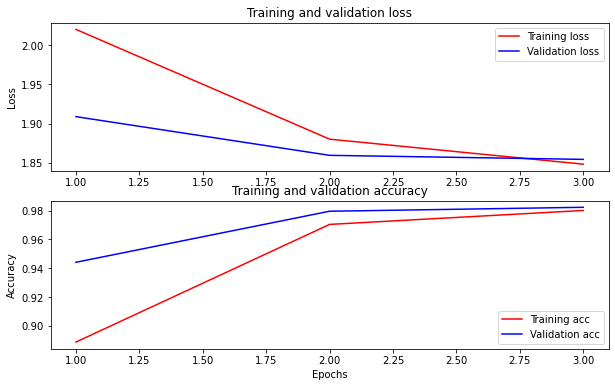

In [37]:
loss, accuracy, topkacc = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

history_dict = history.history
print(history_dict.keys())

acc = history_dict['sparse_top_k_categorical_accuracy']
val_acc = history_dict['val_sparse_top_k_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [39]:
dataset_name = 'boston_DS'
saved_model_path = './{}_bert_noID'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path)

INFO:tensorflow:Assets written to: ./boston_DS_bert_noID\assets


INFO:tensorflow:Assets written to: ./boston_DS_bert_noID\assets


In [25]:
# reloaded_model = tf.saved_model.load(saved_model_path)
reloaded_model = tf.saved_model.load(saved_model_path)

In [38]:
import numpy as np

def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'work for Blue Bottle Cafe RTU connection',
    'Install toilet  sink  lavs  shower  laundry and water heater.',
    'Residential Parking,use of premises for;1 car parking with new driveway  eplan',
    'Low Voltage,To install an intercom door bell system and security camera in the buildingTo install TV cable  in all three floor',
    'Relocate existing smoke detectors and horn/strobes. Install additional smoke detectors and horn/strobes for new 5th. floor office lay-out.'
]

# reloaded_results = reloaded_model(tf.constant(examples))
original_results = classifier_model(tf.constant(examples))
print(class_names)
print(original_results)
print('Results:')
max_ind = np.argmax(original_results.numpy(), axis=1)
for idx in max_ind:
    print('\t',class_names[idx])


['Amendment_to_a_Long_Form', 'Certificate_of_Occupancy', 'Electrical_Fire_Alarms', 'Electrical_Low_Voltage', 'Electrical_Permit', 'Electrical_Temporary_Service', 'Erect_New_Construction', 'Excavation_Permit', 'Foundation_Permit', 'Gas_Permit', 'Long_Form_Alteration_Permit', 'Plumbing_Permit', 'Short_Form_Bldg_Permit', 'Use_of_Premises']
tf.Tensor(
[[3.3215638e-05 1.0027442e-04 4.2889318e-01 5.1022261e-01 1.4127263e-02
  1.5748059e-02 1.9004412e-05 1.5194869e-03 9.0189331e-04 1.6381250e-03
  5.1751063e-05 2.6368570e-02 1.6997439e-05 3.5955606e-04]
 [1.4929084e-07 7.3267290e-07 1.5396800e-07 7.3417186e-07 1.1247987e-07
  4.3993276e-07 1.5403894e-07 8.0228085e-07 5.2466896e-07 5.4096768e-07
  1.1163753e-07 9.9999475e-01 2.4549993e-07 5.0818335e-07]
 [8.3531877e-06 2.8638702e-05 2.4305500e-06 7.5919893e-06 5.2300884e-06
  3.1379977e-06 2.6894809e-04 8.0277832e-06 1.4503854e-05 2.1435675e-05
  3.5931719e-06 2.3567743e-06 2.4393555e-06 9.9962330e-01]
 [5.1933756e-07 5.0649066e-07 5.1803022e-